### For Assignment 1 you should design your own investigation into the citibike data.¶
#### # Come up with a question about the Citibike data usage. It can be anything that involves Categorical data. # At this point of the class it is easier to run tests of proportions or similar, and work with categorical data. Categorical cn be anhything that can be punt into classes (e.g. day/night, male/female, 2014/2015/2016.... as long as you set up your experiment the proper way!)
#### # Choose the significance threshold
#### # Clearly state they Null and Alternate hypothesis
#### # Wrangle the data so that it is ready for your analysis.

### Acknowledging yw3447's comments on the hypothesis

#### Null hypothesis: 
The fraction of Subscribers using bike is at least as high or higher than the fraction of Customers riding a bike in any given week

#### Alternative hypothesis: 
The fraction of Subscribers using bike is less than the fraction of Customers riding a bike in any given week

In [4]:
import pylab as pl
import pandas as pd
import numpy as np
import seaborn
import os
from scipy.optimize import curve_fit, minimize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getCitiBikeCSV(datestring):
    import os
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
getCitiBikeCSV('201401')

file in place, you can continue


In [5]:

df = pd.read_csv(os.getenv("PUIDATA") + "/" + '201401'+ '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,471,2014-01-01 00:00:06,2014-01-01 00:07:57,2009,Catherine St & Monroe St,40.711174,-73.996826,263,Elizabeth St & Hester St,40.717290,-73.996375,16379,Subscriber,1986,1,2014-01-01 00:00:06
1,1494,2014-01-01 00:00:38,2014-01-01 00:25:32,536,1 Ave & E 30 St,40.741444,-73.975361,259,South St & Whitehall St,40.701221,-74.012342,15611,Subscriber,1963,1,2014-01-01 00:00:38
2,464,2014-01-01 00:03:59,2014-01-01 00:11:43,228,E 48 St & 3 Ave,40.754601,-73.971879,2022,E 59 St & Sutton Pl,40.758491,-73.959206,16613,Subscriber,1991,1,2014-01-01 00:03:59
3,373,2014-01-01 00:05:15,2014-01-01 00:11:28,519,Pershing Square N,40.751884,-73.977702,526,E 33 St & 5 Ave,40.747659,-73.984907,15938,Subscriber,1989,1,2014-01-01 00:05:15
4,660,2014-01-01 00:05:18,2014-01-01 00:16:18,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,436,Hancock St & Bedford Ave,40.682166,-73.953990,19830,Subscriber,1990,1,2014-01-01 00:05:18


In [6]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid','gender',
       'birth year'], axis=1, inplace=True)

In [7]:
df.head()

,usertype,date
0,Subscriber,2014-01-01 00:00:06
1,Subscriber,2014-01-01 00:00:38
2,Subscriber,2014-01-01 00:03:59
3,Subscriber,2014-01-01 00:05:15
4,Subscriber,2014-01-01 00:05:18


In [8]:
df['usertype'] = df.usertype.replace('Customer', 2)
df['usertype'] = df.usertype.replace('Subscriber', 1)
df.head()

,usertype,date
0,1,2014-01-01 00:00:06
1,1,2014-01-01 00:00:38
2,1,2014-01-01 00:03:59
3,1,2014-01-01 00:05:15
4,1,2014-01-01 00:05:18


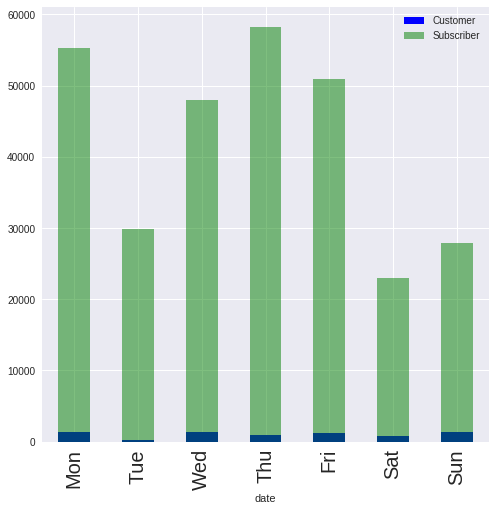

In [9]:
fig=pl.figure(figsize=(8,8))

#instead of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_w = 1
ax=((df['date'][df['usertype'] == 2].groupby([df['date'].dt.weekday]).count()) / norm_w).plot(kind="bar",color='blue',label='Customer')

norm_m = 1
ax = ((df['date'][df['usertype'] == 1].groupby([df['date'].dt.weekday]).count()) / norm_m).plot(kind="bar",color='green',alpha=0.5,label='Subscriber')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
pl.legend()

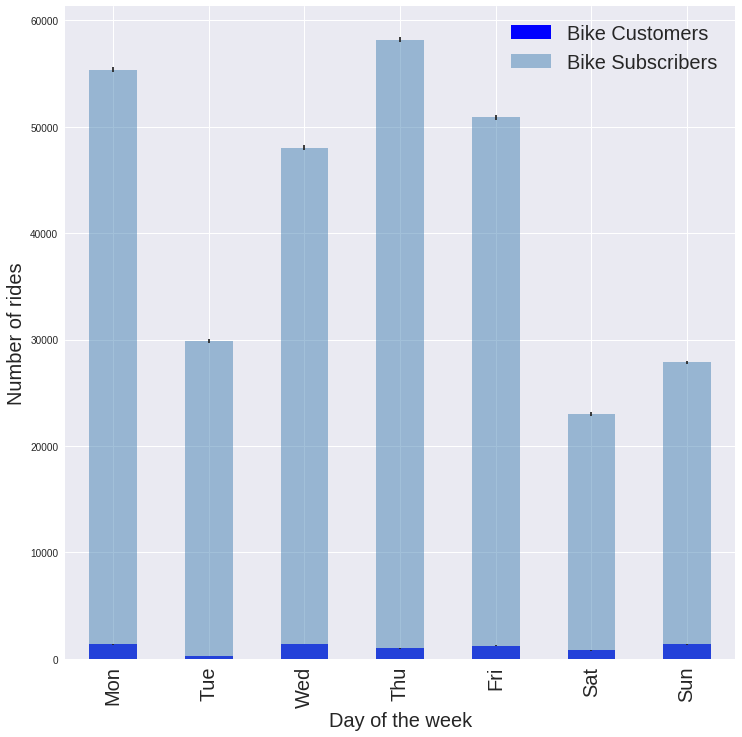

In [10]:
fig=pl.figure(figsize(12,12))

counts_c = df.date[df.usertype == 2].groupby([df.date.dt.weekday]).count()
norm_c = 1
error_c = np.sqrt(counts_c)
ax=((counts_c) / norm_c).plot(kind="bar",color='blue',  yerr=[((error_c) / norm_c, (error_c) / norm_c)], label='Bike Customers')


counts_s = df.date[df.usertype==1].groupby([df.date.dt.weekday]).count()
norm_s = 1
error_s=np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar", alpha=0.5, yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                           color='SteelBlue', label='Bike Subscribers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides",size=20)
ax.set_xlabel ("Day of the week",size=20)
pl.legend(['Bike Customers','Bike Subscribers'],fontsize=20,loc='best')

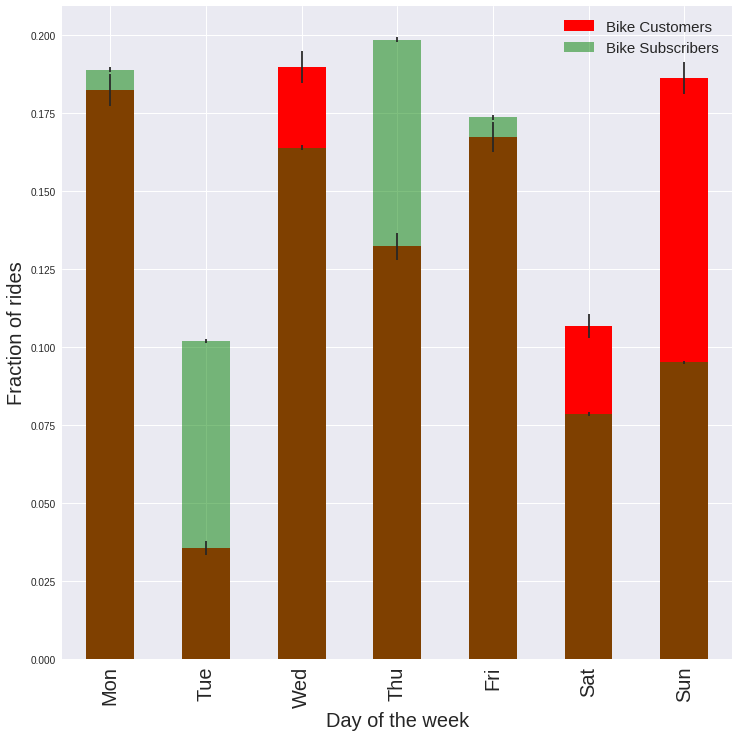

In [11]:
fig = pl.figure(figsize(12,12))

norm_c = counts_c.sum()
error_c = np.sqrt(counts_c)
((counts_c) / norm_c).plot(kind="bar", color='red',  
                           yerr=[((error_c) / norm_c, (error_c) / norm_c)], 
                           label='Bike Customers')

norm_s = counts_s.sum()
ax = ((counts_s) / norm_s).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                                color='green', label='Bike Subscribers')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides",size=20)
ax.set_xlabel ("Day of the week",size=20)

pl.legend(['Bike Customers','Bike Subscribers'],fontsize=15)

### The statistics is:
$z = \frac{(p_0 - p_1)}{SE} $

$p =\frac{p_0  n_0 + p_1  n_1}{n_0+n_1}$

$SE = \sqrt{ p  ( 1 - p )  (\frac{1}{n_0} + \frac{1}{n_1}) }$

and in this notation

$p_0 = \frac{N_{\mathrm{customer}}}{N_{\mathrm{total}}}$

and

$p_1 = \frac{N_{\mathrm{subscriber}}}{N_{\mathrm{total}}}$

In [30]:
normal_s= df.date[df.usertype==1].groupby([df.date.dt.week]).count()
normal_c= df.date[df.usertype==2].groupby([df.date.dt.week]).count()
P0mP1 = sum((counts_s*1.0)/normal_s) - sum((counts_c*1.0)/normal_c)
print ("difference between subscriber and customer is ", P0mP1)
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

difference between subscriber and customer is  0.0778690334609
We must check the significance before we reject the Null Hypothesis


In [50]:
cs = sum(counts_s)*1.
cc = sum(counts_c)*1.
ns = sum(normal_s)*1.
nc = sum(normal_c)*1.

p=(cs*ns)+ (nc*cc) / (nc+ns)
se=p * (1 - p) * (1.0 / ns + 1.0 / nc)
z_score = (cs - cc) / se

In [52]:
print('The z-score for the test is {}'.format(z_score))

The z-score for the test is -2.740486747545452e-13
